### Depthwise Convolution
Model Accuracy : 81.40%(max)

## Importing Keras Libraries and Modules


In [1]:
from keras import backend as K
import numpy as np
import time
# Importing matplot library
import matplotlib.pyplot as plt
% matplotlib inline
# Seed the generator
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout,Input,merge,add,GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers.merge import concatenate
from keras.layers.convolutional import Conv2D,SeparableConv2D

Using TensorFlow backend.


##Importing Cifar10 dataset

In [2]:
# Importing Cifar10 dataset
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


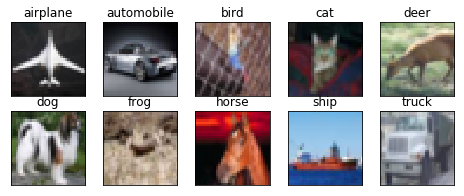

In [3]:
# Ploting each class from cifar10 dataset
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# Function to plot model history
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# Function to define accuracy
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [9]:
# Define the model

from keras.models import Model
input_img = Input(shape=(32,32,3))
# Initial Convolution layer
Conv1 = Conv2D(8,(3,3), activation ='relu' ,name ='Conv1')(input_img)
BN1 = BatchNormalization(name='bn1')(Conv1)
Conv1_1 = Conv2D(16,(3,3), activation ='relu',name ='Conv1_1')(BN1)
BN1_1 = BatchNormalization(name='bn1_1')(Conv1_1)
# Pointwise convolution 1
residual1 = Conv2D(32, (1, 1))(BN1_1)
residual1_1 = BatchNormalization()(residual1)
# Seperable convolution layer 1
SepConv1 = SeparableConv2D(32,3,3, activation='relu',border_mode ='same', name='SepConv1')(residual1_1)
BN2 = BatchNormalization(name='bn2')(SepConv1)
SepConv1_1 = SeparableConv2D(32,3,3, activation='relu',border_mode ='same', name='SepConv1_1')(BN2)
BN2_1 = BatchNormalization(name='bn2_1')(SepConv1_1)
# Adding pointwise layer 1 and seperable convolution layer 1
merge1 = concatenate([BN2_1, residual1_1])
# Pointwise convolution 2
residual2 = Conv2D(64, 1, 1,border_mode='same')(merge1)
residual2_1 = BatchNormalization()(residual2)
# Seperable convolution layer 2
SepConv2 = SeparableConv2D(64,3,3, activation='relu',border_mode ='same', name='SepConv2')(residual2_1)
BN3 = BatchNormalization(name='bn3')(SepConv2)
SepConv2_1 = SeparableConv2D(64,3,3, activation='relu',border_mode ='same', name='SepConv2_1')(BN3)
BN3_1 = BatchNormalization(name='bn3_1')(SepConv2_1)
# Adding pointwise layer 2 and seperable conconvolution layer 2
merge2 = concatenate([BN3_1, residual2_1])

residual3 = Conv2D(128, 1, 1,)(merge2)
residual3_1 = BatchNormalization()(residual3)

SepConv3 = SeparableConv2D(256,3,3, activation='relu',border_mode ='same', name='SepConv3')(residual3_1)
BN4 = BatchNormalization(name='bn4')(SepConv3)
SepConv3_1 = SeparableConv2D(256,3,3, activation='relu',border_mode ='same', name='SepConv3_1')(BN4)
BN4_1 = BatchNormalization(name='bn4_1')(SepConv3_1)

#flat = Flatten(name = 'flatten')(BN4_1)
GAP = GlobalAveragePooling2D(name='avg_pool')(BN4_1)
dense1 = Dense(256, activation='relu', name='fc1')(GAP)
output = Dense(10, activation='softmax')(dense1)
model = Model(inputs=input_img, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Summary of model
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (3, 3), activation="relu", name="SepConv1", padding="same")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (3, 3), activation="relu", name="SepConv1_1", padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(64, (3, 3), activation="relu", name="SepConv2", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 30, 30, 8)    224         input_3[0][0]                    
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 30, 30, 8)    32          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_1 (Conv2D)                (None, 28, 28, 16)   1168        bn1[0][0]                        
__________________________________________________________________________________________________
bn1_1 (Bat

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=50, validation_data=(array([[[..., verbose=1, steps_per_epoch=390)`
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/50
390/390 [==============================] - 44s 113ms/step - loss: 1.3449 - acc: 0.5092 - val_loss: 1.3359 - val_acc: 0.5430
Epoch 2/50
390/390 [==============================] - 38s 98ms/step - loss: 0.9896 - acc: 0.6446 - val_loss: 0.9856 - val_acc: 0.6481
Epoch 3/50
390/390 [==============================] - 38s 98ms/step - loss: 0.8427 - acc: 0.7011 - val_loss: 0.9140 - val_acc: 0.6795
Epoch 4/50
390/390 [==============================] - 39s 99ms/step - loss: 0.7379 - acc: 0.7397 - val_loss: 0.8770 - val_acc: 0.7029
Epoch 5/50
390/390 [==============================] - 39s 99ms/step - loss: 0.6530 - acc: 0.7727 - val_loss: 0.7398 - val_acc: 0.7457
Epoch 6/50
390/390 [==============================] - 39s 100ms/step - loss: 0.5720 - acc: 0.8008 - val_loss: 0.7036 - val_acc: 0.7615
Epoch 7/50
390/390 [==============================] - 39s 100ms/step - loss: 0.5114 - acc: 0.8207 - val_loss: 0.8414 - val_acc: 0.7199
Epoch 8/50
390/390 [==============================] - 39s 1

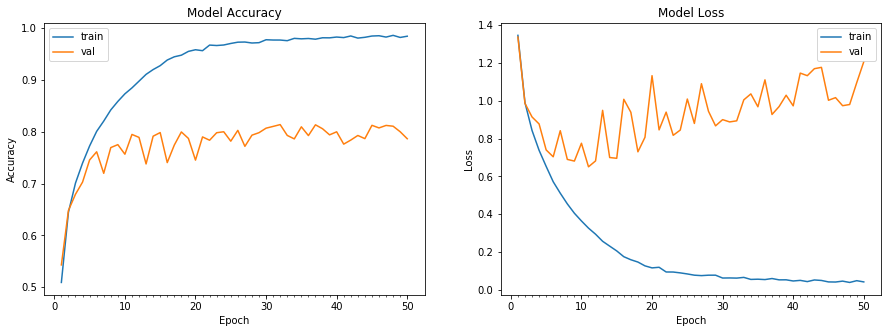

Accuracy on test data is: 78.67


In [10]:
# Image Normalization
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0,horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], epochs = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

# plot model history
plot_model_history(model_info)

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))